# Recurrent Neural Network with Tensorflow

For this exercise I will be using the "Monthly milk production: pounds per cow. Jan 62 – Dec 75" dataset. I will be using a vanilla RNN model, LSTM and a GRU.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

In [3]:
milk.shape

(168, 1)

In [4]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [5]:
milk.index = pd.to_datetime(milk.index)

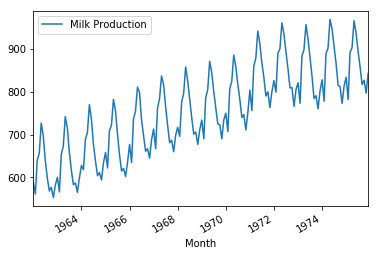

In [6]:
milk.plot()

As we can see there is a general trend and seasonality

### Train-Test split

Since this is a timeseries data, we are not spliting the data randomly. We will use the first 13 years (1962-1974) for the training and the last year for testing.

In [7]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [8]:
num_time_steps = 24
train_set = milk[:156]
test_set = milk[-num_time_steps:]

### Data Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

### Mini-Batches

In [12]:
def next_batch(training_data, batch_size, steps):
    rand_start = np.random.randint(0,len(training_data)-steps)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

### Constants

In [13]:
num_inputs = 1

num_neurons = 200
num_outputs = 1

learning_rate = 0.001
num_train_iterations = 4000
batch_size = 1

### Tensorflow

In [14]:
import tensorflow as tf

In [15]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

### Train: LSTM

In [16]:
tf.reset_default_graph()

In [17]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [18]:
lstm_cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [19]:
outputs, states = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)

In [22]:
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [23]:
init = tf.global_variables_initializer()

In [24]:
saver_lstm = tf.train.Saver()

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [26]:
with tf.Session(config = config) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver_lstm.save(sess, "G:/models/rnn/lstm.ckpt")

0 	MSE: 0.0743703
100 	MSE: 0.0309635
200 	MSE: 0.0319249
300 	MSE: 0.0142891
400 	MSE: 0.00810319
500 	MSE: 0.0114653
600 	MSE: 0.00657246
700 	MSE: 0.0122758
800 	MSE: 0.00670499
900 	MSE: 0.00650685
1000 	MSE: 0.00554057
1100 	MSE: 0.00793242
1200 	MSE: 0.00604266
1300 	MSE: 0.004354
1400 	MSE: 0.00398685
1500 	MSE: 0.00291705
1600 	MSE: 0.0046708
1700 	MSE: 0.00459161
1800 	MSE: 0.0044283
1900 	MSE: 0.00434094
2000 	MSE: 0.00570198
2100 	MSE: 0.00462251
2200 	MSE: 0.00478022
2300 	MSE: 0.00550958
2400 	MSE: 0.00348277
2500 	MSE: 0.00349413
2600 	MSE: 0.00336778
2700 	MSE: 0.003083
2800 	MSE: 0.00353522
2900 	MSE: 0.00225457
3000 	MSE: 0.0021219
3100 	MSE: 0.00265739
3200 	MSE: 0.00363631
3300 	MSE: 0.00209543
3400 	MSE: 0.00310374
3500 	MSE: 0.002577
3600 	MSE: 0.00299599
3700 	MSE: 0.00234048
3800 	MSE: 0.00166506
3900 	MSE: 0.00223745


### Test: LSTM

In [27]:
with tf.Session() as sess:
    
    saver_lstm.restore(sess, "G:/models/rnn/lstm.ckpt")

    train_seed = list(train_scaled[-num_time_steps:])
    
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from G:/models/rnn/lstm.ckpt


In [28]:
train_seed

[array([ 0.64423077]),
 array([ 0.52884615]),
 array([ 0.79326923]),
 array([ 0.82932692]),
 array([ 0.97115385]),
 array([ 0.89182692]),
 array([ 0.78846154]),
 array([ 0.68269231]),
 array([ 0.55528846]),
 array([ 0.57211538]),
 array([ 0.49759615]),
 array([ 0.59855769]),
 array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.6799385,
 0.55247998,
 0.82332611,
 0.85166782,
 1.0182052,
 0.9471733,
 0.83282346,
 0.72350162,
 0.59841108,
 0.58884847,
 0.48080212,
 0.57439482]

In [29]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(num_time_steps,1))

In [30]:
test_set.shape

(24, 1)

In [31]:
results.shape

(24, 1)

In [32]:
test_set['Generated'] = results

C:\Users\nickj\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
test_set = test_set[-12:]

In [34]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,835.854414
1975-02-01 01:00:00,782.0,782.831673
1975-03-01 01:00:00,892.0,895.503662
1975-04-01 01:00:00,903.0,907.293814
1975-05-01 01:00:00,966.0,976.573349
1975-06-01 01:00:00,937.0,947.024092
1975-07-01 01:00:00,896.0,899.454557
1975-08-01 01:00:00,858.0,853.976675
1975-09-01 01:00:00,817.0,801.939011


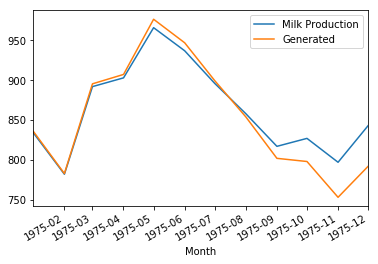

In [35]:
test_set.plot()

### MAPE

In [36]:
np.mean(np.abs((test_set['Milk Production'] - test_set['Generated'])/test_set['Milk Production']))

0.01762132809845583

### Train: GRU

In [37]:
test_set = milk[-num_time_steps:]

In [38]:
tf.reset_default_graph()

In [39]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [40]:
gru_cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [41]:
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32)

In [42]:
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [43]:
init = tf.global_variables_initializer()

In [44]:
saver_gru = tf.train.Saver()

In [45]:
with tf.Session(config = config) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver_gru.save(sess, "G:/models/rnn/gru.ckpt")

0 	MSE: 0.0759676
100 	MSE: 0.0347327
200 	MSE: 0.00892236
300 	MSE: 0.0178883
400 	MSE: 0.00751884
500 	MSE: 0.00846497
600 	MSE: 0.00416726
700 	MSE: 0.00449581
800 	MSE: 0.00346507
900 	MSE: 0.00475894
1000 	MSE: 0.003279
1100 	MSE: 0.00433433
1200 	MSE: 0.00384896
1300 	MSE: 0.00129454
1400 	MSE: 0.00369343
1500 	MSE: 0.00278669
1600 	MSE: 0.00214033
1700 	MSE: 0.00336995
1800 	MSE: 0.00418337
1900 	MSE: 0.00355115
2000 	MSE: 0.00145271
2100 	MSE: 0.00394316
2200 	MSE: 0.00501655
2300 	MSE: 0.00233972
2400 	MSE: 0.00232763
2500 	MSE: 0.00153097
2600 	MSE: 0.00233622
2700 	MSE: 0.00269739
2800 	MSE: 0.00265862
2900 	MSE: 0.00326974
3000 	MSE: 0.00153937
3100 	MSE: 0.0019306
3200 	MSE: 0.00282931
3300 	MSE: 0.00342939
3400 	MSE: 0.00236774
3500 	MSE: 0.00410363
3600 	MSE: 0.00579932
3700 	MSE: 0.00114259
3800 	MSE: 0.00358002
3900 	MSE: 0.0020445


### Test: GRU

In [46]:
with tf.Session() as sess:
    
    saver_lstm.restore(sess, "G:/models/rnn/gru.ckpt")

    train_seed = list(train_scaled[-num_time_steps:])

    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from G:/models/rnn/gru.ckpt


In [47]:
train_seed

[array([ 0.64423077]),
 array([ 0.52884615]),
 array([ 0.79326923]),
 array([ 0.82932692]),
 array([ 0.97115385]),
 array([ 0.89182692]),
 array([ 0.78846154]),
 array([ 0.68269231]),
 array([ 0.55528846]),
 array([ 0.57211538]),
 array([ 0.49759615]),
 array([ 0.59855769]),
 array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.68220276,
 0.62646151,
 0.75674921,
 0.86383897,
 0.9950645,
 0.93319398,
 0.83418584,
 0.73747164,
 0.64745563,
 0.6482721,
 0.59083569,
 0.61713034]

In [48]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(num_time_steps,1))

In [49]:
test_set.shape

(24, 1)

In [50]:
results.shape

(24, 1)

In [51]:
test_set['Generated'] = results

C:\Users\nickj\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
test_set = test_set[-12:]

In [53]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,836.796347
1975-02-01 01:00:00,782.0,813.607986
1975-03-01 01:00:00,892.0,867.807673
1975-04-01 01:00:00,903.0,912.357012
1975-05-01 01:00:00,966.0,966.946831
1975-06-01 01:00:00,937.0,941.208696
1975-07-01 01:00:00,896.0,900.021309
1975-08-01 01:00:00,858.0,859.788202
1975-09-01 01:00:00,817.0,822.341543


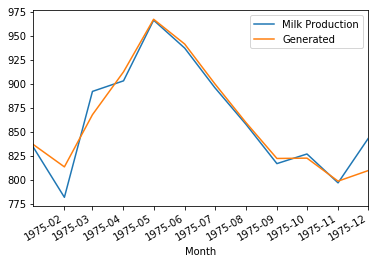

In [54]:
test_set.plot()

### MAPE

In [55]:
np.mean(np.abs((test_set['Milk Production'] - test_set['Generated'])/test_set['Milk Production']))

0.012231156985944546

### Conclusion

I ran both models multiple times and their MAPE fluctuated at around 1%. However, GRU's MAPE was generally lower than the LSTM's